#                                Scania APS Component failure prediction

## 1) Problem statement.

Data Source: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks

**Data:** Scania Trucks Sensor data

**Problem statement :**
- The system in focus is the Air Pressure system (APS) which generates pressurized air that are utilized in various functions in a truck, such as braking and gear changes. The datasets positive class corresponds to component failures for a specific component of the APS system. The negative class corresponds to trucks with failures for components not related to the APS system.

- The problem is to reduce the cost due to unnecessary repairs. So it is required to minimize the false predictions.

|True class | Positive | Negative ||
| ----------- | ----------- |   |  |
|<b>Predicted class</b>|||
| Positive      |   -       | cost_1  |    |
| Negative   | cost_2        |  | |


Cost_1 = 10 and Cost_2 = 500

- The total cost of a prediction model the sum of `Cost_1` multiplied by the number of Instances with type 1 failure and `Cost_2` with the number of instances with type 2 failure, resulting in a `Total_cost`. In this case Cost_1 refers to the cost that an unnessecary check needs to be done by an mechanic at an workshop, while Cost_2 refer to the cost of missing a faulty truck, which may cause a breakdown. `Total_cost = Cost_1 * No_Instances + Cost_2 * No_Instances.`

- From the above problem statement we could observe that, we have to reduce false positives and false negatives. More importantly we have to **reduce false negatives, since cost incurred due to false negative is 50 times higher than the false positives.**

## Challenges and other objectives

- Need to Handle many Null values in almost all columns
- No low-latency requirement.
- Interpretability is not important.
- misclassification leads the unecessary repair costs.

## 2) Import required libraries

In [61]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import PowerTransformer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_mode
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix


from sklearn import metrics 
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")
%matplotlib inline

### Read Data

In [2]:
df = pd.read_csv(r'D:\iNeuron\Data Squad\ML-Projects\Scania Truck Air pressure\aps_failure_training_set.csv', na_values="na")

In [3]:
df.shape

(60000, 171)

In [4]:
df['class'].value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

In [5]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 170 numerical features : ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000'

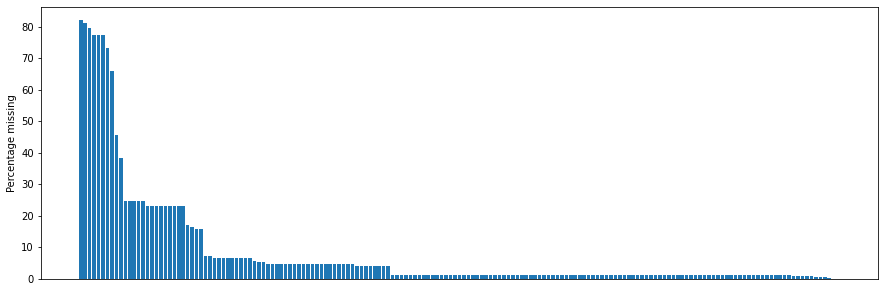

In [7]:
fig, ax = plt.subplots(figsize=(15,5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)

ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

In [8]:
dropcols = missing[missing[0]>70]
dropcols

,0
br_000,82.106667
bq_000,81.203333
bp_000,79.566667
bo_000,77.221667
ab_000,77.215000
cr_000,77.215000
bn_000,73.348333


In [15]:
df.drop(list(dropcols.index), axis=1, inplace=True)

In [16]:
df.shape

(60000, 164)

In [48]:
df['class'].value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

Positive: 1000, Negative: 59000


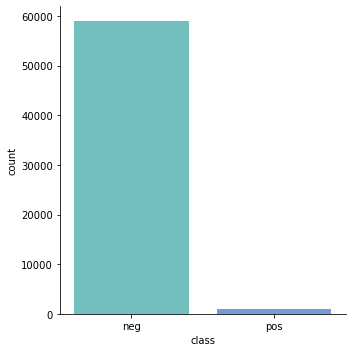

In [50]:
pos = df[df['class']=='pos'].shape[0]
neg = df[df['class']=='neg'].shape[0]
print("Positive: " + str(pos) + ", Negative: " + str(neg))
sns.catplot(data=df, x="class", kind="count", palette="winter_r", alpha=.6)
plt.show()

# imputation

In [62]:
def total_cost(test_y, predict_y):
    '''
    This function takes y_ture, y_predicted, and prints Total cost due to misclassification
   
    '''
    C = confusion_matrix(test_y, predict_y)
    cost_1 = 10*C[0][1]
    cost_2 = 500*C[1][0]
    total = (cost_1 + cost_2)
    return total

In [18]:
missing_values_count= df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
(total_missing/total_cells) * 100

5.29765243902439

In [19]:
total_cells

9840000

In [20]:
total_missing

521289

In [51]:
X= df.drop('class', axis=1)
y = df['class']

In [52]:
from sklearn.impute import KNNImputer
knn = KNNImputer(n_neighbors = 3)
data = knn.fit_transform(X)

In [53]:
y= y.replace({'pos': 1, 'neg': 0})

In [54]:
from imblearn.combine import SMOTETomek

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(data, y)

In [58]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((94392, 163), (23598, 163))

In [59]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [63]:
def model_train_evaluation(models_dictionary):
    cost_list=[]
    models_list = []
    
    for i in range(len(list(models_dictionary))):
        model = list(models_dictionary.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models_dictionary.keys())[i])
        models_list.append(list(models_dictionary.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        accuracy_list.append(model_test_accuracy)
        print('='*35)
        print('\n')
        
        report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])
        
        return report

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9959
- F1 score: 0.9958
- Precision: 0.9924
- Recall: 0.9993
- Roc Auc Score: 0.9959
- COST: 4890.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9917
- F1 score: 0.9916
- Precision: 0.9878
- Recall: 0.9955
- Roc Auc Score: 0.9918
- COST: 27430.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9849
- F1 score: 0.9850
- Precision: 0.9820
- Recall: 0.9879
- Roc Auc Score: 0.9848
- COST: 295070.
----------------------------------
Model performance for Test set
- Accuracy: 0.9842
- F1 score: 0.9840
- Precision: 0.9795
- Recall: 0.9885
- Roc Auc 

## after scaling

In [73]:
num_features = X.select_dtypes(exclude="object").columns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer


pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

In [74]:
data1 =pipeline.fit_transform(X)

In [75]:
data1

array([[2.79250729e-02, 9.99999832e-01, 3.26176944e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.20361295e-02, 0.00000000e+00, 1.46779625e-08, ...,
        3.93692728e-04, 0.00000000e+00, 0.00000000e+00],
       [1.49423061e-02, 1.07006746e-07, 1.16491766e-08, ...,
        1.34905375e-04, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.07782233e-05, 9.99999829e-01, 2.09685178e-09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.92336170e-02, 9.99999829e-01, 5.75469322e-08, ...,
        1.01945944e-01, 0.00000000e+00, 0.00000000e+00],
       [1.46444794e-02, 3.27590826e-07, 7.31568288e-08, ...,
        4.14689673e-05, 0.00000000e+00, 0.00000000e+00]])

In [77]:
from imblearn.combine import SMOTETomek, SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(data1, y)

In [78]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((93026, 163), (23257, 163))

In [79]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

accuracy_list=[]
models_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy, model_train_f1,model_train_precision,\
    model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
    train_cost = total_cost(y_train, y_train_pred)


    # Test set performance
    model_test_accuracy,model_test_f1,model_test_precision,\
    model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
    test_cost = total_cost(y_test, y_test_pred)

    print(list(models.keys())[i])
    models_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1)) 
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
    print(f'- COST: {train_cost}.')

    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
    print(f'- COST: {test_cost}.')

    accuracy_list.append(test_cost)


    print('='*35)
    print('\n')

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9975
- F1 score: 0.9976
- Precision: 0.9956
- Recall: 0.9995
- Roc Auc Score: 0.9975
- COST: 3510.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9930
- F1 score: 0.9930
- Precision: 0.9905
- Recall: 0.9955
- Roc Auc Score: 0.9930
- COST: 27110.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9876
- F1 score: 0.9878
- Precision: 0.9870
- Recall: 0.9887
- Roc Auc Score: 0.9876
- COST: 273650.
----------------------------------
Model performance for Test set
- Accuracy: 0.9856
- F1 score: 0.9856
- Precision: 0.9847
- Recall: 0.9866
- Roc Auc 

In [82]:
pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])

,Model Name,Cost
5,XGBClassifier,3250
0,Random Forest,3510
4,K-Neighbors Classifier,4720
6,CatBoosting Classifier,5390
1,Decision Tree,27110
2,Gradient Boosting,79790
8,AdaBoost Classifier,166400
7,Support Vector Classifier,175330
3,Logistic Regression,315220


## Mice forest

In [87]:
import miceforest as mf

data2 = X.copy()
kernel = mf.ImputationKernel(
  data2,
  save_all_iterations=True,
  random_state=1989
)# Run the MICE algorithm for 3 iterations on each of the datasets
kernel.mice(3)

In [91]:
data2 = kernel.complete_data()

In [93]:
from imblearn.combine import SMOTETomek, SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(data2, y)

In [96]:
minmax = MinMaxScaler()
X_res = minmax.fit_transform(X_res)

In [97]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((92733, 163), (23184, 163))

In [98]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

accuracy_list=[]
models_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy, model_train_f1,model_train_precision,\
    model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
    train_cost = total_cost(y_train, y_train_pred)


    # Test set performance
    model_test_accuracy,model_test_f1,model_test_precision,\
    model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
    test_cost = total_cost(y_test, y_test_pred)

    print(list(models.keys())[i])
    models_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1)) 
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
    print(f'- COST: {train_cost}.')

    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
    print(f'- COST: {test_cost}.')

    accuracy_list.append(test_cost)


    print('='*35)
    print('\n')

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9975
- F1 score: 0.9975
- Precision: 0.9957
- Recall: 0.9992
- Roc Auc Score: 0.9974
- COST: 5000.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9930
- F1 score: 0.9930
- Precision: 0.9911
- Recall: 0.9950
- Roc Auc Score: 0.9930
- COST: 30040.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9894
- F1 score: 0.9896
- Precision: 0.9885
- Recall: 0.9907
- Roc Auc Score: 0.9894
- COST: 224430.
----------------------------------
Model performance for Test set
- Accuracy: 0.9881
- F1 score: 0.9882
- Precision: 0.9877
- Recall: 0.9887
- Roc Auc 

In [99]:
pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])

,Model Name,Cost
5,XGBClassifier,4780
0,Random Forest,5000
6,CatBoosting Classifier,8460
4,K-Neighbors Classifier,10920
1,Decision Tree,30040
2,Gradient Boosting,67430
7,Support Vector Classifier,131850
8,AdaBoost Classifier,136170
3,Logistic Regression,273280


## Simple CONSTANT

In [101]:
num_features = X.select_dtypes(exclude="object").columns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer


pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', MinMaxScaler())
])

In [102]:
data3 =pipeline.fit_transform(X)

In [104]:
from imblearn.combine import SMOTETomek, SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(data3, y)

In [105]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((94374, 163), (23594, 163))

In [106]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

accuracy_list=[]
models_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy, model_train_f1,model_train_precision,\
    model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
    train_cost = total_cost(y_train, y_train_pred)


    # Test set performance
    model_test_accuracy,model_test_f1,model_test_precision,\
    model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
    test_cost = total_cost(y_test, y_test_pred)

    print(list(models.keys())[i])
    models_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1)) 
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
    print(f'- COST: {train_cost}.')

    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
    print(f'- COST: {test_cost}.')

    accuracy_list.append(test_cost)


    print('='*35)
    print('\n')

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9960
- F1 score: 0.9960
- Precision: 0.9930
- Recall: 0.9990
- Roc Auc Score: 0.9961
- COST: 6820.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9909
- F1 score: 0.9908
- Precision: 0.9873
- Recall: 0.9944
- Roc Auc Score: 0.9910
- COST: 33990.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9831
- F1 score: 0.9832
- Precision: 0.9797
- Recall: 0.9867
- Roc Auc Score: 0.9831
- COST: 324670.
----------------------------------
Model performance for Test set
- Accuracy: 0.9805
- F1 score: 0.9804
- Precision: 0.9753
- Recall: 0.9855
- Roc Auc 

In [128]:
num_features = X.select_dtypes(exclude="object").columns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer


pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

In [129]:
data4 = pipeline.fit_transform(X)

In [133]:
from imblearn.combine import SMOTETomek, SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(data4, y)

In [134]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((94384, 163), (23596, 163))

In [135]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

accuracy_list=[]
models_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy, model_train_f1,model_train_precision,\
    model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
    train_cost = total_cost(y_train, y_train_pred)


    # Test set performance
    model_test_accuracy,model_test_f1,model_test_precision,\
    model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
    test_cost = total_cost(y_test, y_test_pred)

    print(list(models.keys())[i])
    models_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1)) 
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
    print(f'- COST: {train_cost}.')

    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
    print(f'- COST: {test_cost}.')

    accuracy_list.append(test_cost)


    print('='*35)
    print('\n')

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9970
- F1 score: 0.9970
- Precision: 0.9949
- Recall: 0.9990
- Roc Auc Score: 0.9970
- COST: 6590.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9927
- F1 score: 0.9926
- Precision: 0.9887
- Recall: 0.9966
- Roc Auc Score: 0.9928
- COST: 21320.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9843
- F1 score: 0.9844
- Precision: 0.9817
- Recall: 0.9871
- Roc Auc Score: 0.9843
- COST: 315210.
----------------------------------
Model performance for Test set
- Accuracy: 0.9836
- F1 score: 0.9833
- Precision: 0.9809
- Recall: 0.9858
- Roc Auc 

## pca

In [111]:
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer

In [112]:
def my_scorer(y_true,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp+500*fn
    return cost

my_func = make_scorer(my_scorer, greater_is_better=False)

In [130]:
from imblearn.combine import SMOTETomek, SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(data1, y)

In [131]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(n_jobs=-1) # initialising SVC classifier
pca = PCA() # initialising PCA component

pipe = Pipeline(steps=[("pca",pca), ("clf",clf)]) # creating pipeline

# hyperparameters grid to be investigated
param_grid = {
    'pca__n_components': range(10,100),
}

search = GridSearchCV(pipe, param_grid, cv=3, return_train_score=False, scoring=my_func, n_jobs=-1, verbose=3) # Grid Search with 3-fold CV
search.fit(X_res, y_res)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('clf', LogisticRegression(n_jobs=-1))]),
             n_jobs=-1, param_grid={'pca__n_components': range(10, 100)},
             scoring=make_scorer(my_scorer, greater_is_better=False),
             verbose=3)

In [132]:
# Plotting best classificator
print("Best parameters (CV score: {:0.3f}):".format(search.best_score_))
print(search.best_params_)

Best parameters (CV score: -554043.333):
{'pca__n_components': 98}


## Final Model